In [1]:
import networkx as nx
from collections import defaultdict
from csv import DictReader, writer
import pandas as pd 
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score, homogeneity_score
import random
import time
from igraph import *
import numpy as np
import graph_tool.all as gt
import csv


### import graph data

In [32]:
start = time.time()
df = pd.read_csv("data/edgeData/edges_2011_2_2013_1.csv")
#df.drop(['pair_txt'], axis=1, inplace=True)
df["sum"] = df[["h0", "h1", "h2", "h3", "h4", "h5", "h6"]].sum(axis=1)
print(time.time()-start)

6.328248977661133


In [33]:
df.head()

node1                               node2  h0  \
0  1111219E1WdFoSBE3WVmY3uvHkq2NvnuV  1969VR2qCchXMW94tpcYirbVLUfFw4Pw7b   0   
1  111133WxWTrHrru31e3cBPWGErh7Vrifr  115SszjCNfn8daZxfnN4C9EW4fBLknXPKX   0   
2  111133WxWTrHrru31e3cBPWGErh7Vrifr  14WChGtct4AgzUZea7YT583DX4R6MfHHVB   0   
3  111133WxWTrHrru31e3cBPWGErh7Vrifr  14j7F9Sj75zaRhEtBQb5jVyn7VgvucP3Yw   0   
4  111133WxWTrHrru31e3cBPWGErh7Vrifr  172oaECE1gbHWevs8HCqfAMC1Ru3YnmW1T   0   

   h1  h2  h3  h4  h5  h6  sum  
0   2   0   2   2   0   2    8  
1   1   0   1   1   0   1    4  
2   1   0   1   1   0   1    4  
3   1   0   1   1   0   1    4  
4   1   0   1   1   0   1    4

### import ground truth

In [53]:
df_gt = pd.read_csv('data/ground_truth_id.csv.zip')
print(df_gt.shape)

df_gt = df_gt.dropna(axis=0, how='any', subset=["address", "entity"])
print(df_gt.shape)

df_gt = df_gt.drop_duplicates(subset="address", keep=False)
print(df_gt.shape)

entity_counts = df_gt["entity"].value_counts()
rare_entities = entity_counts[entity_counts < 10].index
df_gt = df_gt.loc[~df_gt["entity"].isin(rare_entities), :]
print(df_gt.shape)

df_gt.head()

(28027931, 4)
(28027931, 4)
(28027089, 4)
(28027060, 4)


address       entity    sector          id
0  1E421ChpHWEqQ2Kcy2JqEE8eDx7nFN4AXj  777Coin.com  Gambling  34916770.0
1  15uWGv4QFoa7Hjkfzs6YCDVGNhxZ4Yz2wW  777Coin.com  Gambling  26152409.0
2  19s8Jzb6fQ9kLu3Gcb46aX5h9uc93PULgC  777Coin.com  Gambling  29354407.0
3  1LfiL43VHwe2tRNjra5uhVAc4J5nFUay5X  777Coin.com  Gambling  29902318.0
4  1Bh6y3BkJVzodfGfLh9GCuuKPqgwoyRibF  777Coin.com  Gambling  29739794.0

In [64]:
gt_addr = set(df_gt["address"])
sample_addr = set(df["node1"]).union(set(df["node2"]))
known_addr = sample_addr.intersection(gt_addr)

print('ground truth addresses',len(gt_addr))
print('sample addressses:',len(sample_addr))
print('ground truth addresses in sample',len(known_addr))

ground truth addresses 28027060
sample addressses: 191453
ground truth addresses in sample 155449


In [65]:
df_gt_known = df_gt.loc[df_gt["address"].isin(sample_addr), ['address', 'entity']]

known_entities = set(df_gt_known['entity'])

# known_entity_addr_dict = {idx: set(df_gt_known.loc[df_gt_known["entity"] == e, "address"]) for idx, e in enumerate(known_entities)}

known_addr_entity_dict_list = [{a: idx for a in set(df_gt_known.loc[df_gt_known["entity"] == e, "address"])}
                               for idx, e in enumerate(known_entities)]
known_addr_entity_dict = {}
[known_addr_entity_dict.update(d) for d in known_addr_entity_dict_list]

known_entity_counts = df_gt_known['entity'].value_counts().rename("count").to_frame()

print('ground truth entities in sample:',len(known_entities))
known_entity_counts

ground truth entities in sample: 68


count
BTC-e.com          87417
BitPay.com         63172
CoinJoinMess        1253
Bitstamp.net         897
Cryptsy.com          434
...                  ...
NitrogenSports.eu      1
HappyCoins.com         1
AgoraMarket            1
Coinroll.com           1
BtcMarkets.net         1

[68 rows x 1 columns]

In [7]:
def get_labels(cs_addr, known_addr_entity_dict):
    res = {}
    for idx, c in enumerate(cs_addr):
        for a in c:
            if a in known_addr:
                res[a] = idx
                
    labels_true = [] 
    labels_pred = []

    for a in res.keys():
        labels_true.append(known_addr_entity_dict[a])
        labels_pred.append(res[a])
    
    return labels_true, labels_pred

In [8]:
edge_tuples = df[["node1", "node2", "sum"]].itertuples(index=False)
g = Graph.TupleList(edge_tuples, directed=False, weights=True)
summary(g)

IGRAPH UNW- 329240 50552843 -- 
+ attr: name (v), weight (e)


# Degree Distribution

In [269]:
fit = powerlaw.Fit([3,3,3,2,2,3,4,4,4,4,3,3], xmin=1)
fit.distribution_compare('power_law', 'lognormal')
fit.power_law.plot_pdf()

(-13.898750375364319, 6.532852271865813e-08)

In [272]:
fit.alpha

1.8873675112515635

/home/jpalec/anaconda3/envs/graphs/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


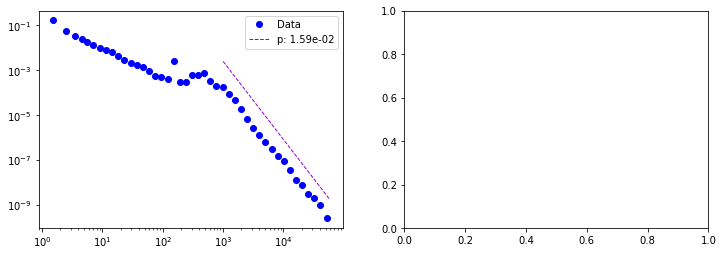

In [263]:
import matplotlib.pyplot as plt
from collections import Counter
import powerlaw
import matplotlib

in_deg = Graph.indegree(g)
out_deg = Graph.outdegree(g)
in_deg = np.array(in_deg)
out_deg = np.array(out_deg)

def power_fit(degrees):
    fit = powerlaw.Fit(degrees, xmin=1000)
    alpha = fit.power_law.alpha
    err = fit.power_law.sigma
    return (degrees, fit, alpha, err)

Fit.distribution_compare('power_law', 'lognormal')

degs, fit, alpha, sigma = power_fit(in_deg)
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax = ax.ravel()
powerlaw.plot_pdf(in_deg,c='blue', marker='o', linestyle='', linewidth=1, label='Data' ,ax= ax[0])
fit.power_law.plot_pdf(in_deg, c='darkviolet', linestyle='--', linewidth=1, label='p: {:.2e}'.format(sigma) ,ax=ax[0])
ax[0].legend()



In [106]:
fit[1].distribution_compare('power_law', 'lognormal')

(-0.818944696830977, 0.4524955575595052)

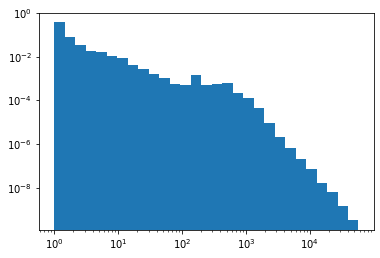

In [173]:
bins = np.logspace(np.log10(out_deg.min()), np.log10(out_deg.max()), 30)
plt.hist(out_deg, density=True, bins=bins, linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [38]:
dist = g.degree_distribution(bin_width=1)

In [65]:
dist._get_bin(100)

99

In [68]:
def get_initial_and_fixed(sample_size):
    known_idxs = [idx for idx, addr in enumerate(g.vs["name"]) if addr in known_addr]

    initial = np.zeros(len(g.vs), dtype=np.int)
    
    rng = np.random.RandomState(32512163)
    
    sample_known_idxs = rng.choice(known_idxs, size=sample_size, replace=False) # TODO: set seed
    non_sample_idxs = np.setdiff1d(range(len(g.vs)), sample_known_idxs)

    for idx in sample_known_idxs:
        initial[idx] = known_addr_entity_dict[g.vs[idx]["name"]]

    initial[non_sample_idxs] = range(sample_size, len(g.vs))
    
    fixed = np.zeros(len(g.vs), dtype=np.int)
    fixed[sample_known_idxs] = 1
    fixed = fixed.astype(bool)
    
    return initial, fixed

In [69]:
#Clusters
initial, fixed = get_initial_and_fixed(11)
lp = g.community_label_propagation(weights="weight", initial=initial, fixed=fixed)
print('number of clusters',len(lp))

#Cluster as dict
node_dict = {node:c_id for (c_id,cluster) in enumerate(lp) for node in cluster}
with open('data/gt_plots/node_clusters.csv','w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in node_dict.items():
        writer.writerow([key, value])
        
#Export edge list
edge_file = 'data/gt_plots/edges.csv'
g.write_edgelist(edge_file)

number of clusters 210


In [70]:
G = gt.load_graph_from_csv(edge_file, directed=False, csv_options={'delimiter': ' '})
cluster = G.new_vp(value_type='int', vals=node_dict.values())
G.vertex_properties["cluster"] = cluster
G.vp.cluster

<VertexPropertyMap object with value type 'int32_t', for Graph 0x7f8a5af244a8, at 0x7f8a5bb517f0>

In [71]:
G.vp.cluster

<VertexPropertyMap object with value type 'int32_t', for Graph 0x7f8a5af244a8, at 0x7f8a5bb517f0>

In [72]:
gt.label_components(G)[1]

array([191430,      7,      6,     10], dtype=uint64)

### Plot

In [73]:
start = time.time()
loc1 = gt.sfdp_layout(G, groups=G.vp.cluster)
print("duration: {0:.2f} sec".format(time.time() - start))

start = time.time()
gt.graph_draw(G, edge_color='lightgrey', edge_pen_width=0.08, vertex_size=3,
             vertex_fill_color=G.vp.cluster, vcmap=cm.magma, 
             pos=loc1, output_size=(300,300), output="data/gt_plots/2013_2_sfdp_seed11_1.png");
print("duration: {0:.2f} sec".format(time.time() - start))

duration: 463.60 sec
duration: 1757.81 sec


In [252]:
def count(d):
    r = d.replace('[','')
    r = r.replace(']','')
    r = np.array([int(x) for x in r.split(',')])
    return np.unique(r, return_counts=True)

In [256]:
g1 = pd.read_csv('data/res/edges_2015_1_0_res_20210111_1607_1610381268.csv')
d1 = g1.cluster_sizes[0]
d2 = g1.cluster_sizes[11]

In [257]:
d1 = g1.cluster_sizes[0]
d1 = count(d1)
d2 = count(d2)

In [262]:
power_fit(degrees)

<function __main__.power_fit>

In [ ]:
d1[1]

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].scatter(d1[0], d1[1])
